# Introduction

The universal workflow of machine learning given in the chapter 4.5 of "Deep Learning with Python" by François Chollet contains five major steps: data loading, data preprocessing, building of a network (model), training the model and testing the model.[1]

The dataset we are going to work on is "ag_news_subset" which is a collection of more than 100,00 news articles classified into four classes: World, Sports, Business and Sci/Tech [2]. This dataset is a part of Tensoflow datasets package availabe at Tensorflow official website.[3] It has 120,000 training and 7,600 testing samples. The problem we are going to try and solve using this dataset is a text classification\categorization problem.

## Common sense baseline

A common sense baseline is a way to solve the task using conventional methods not involving the machine learning. Text classification problem like this one could be solved by maitaining category-related vocabularies and calculating statistics of how many words belonging to target categories are found within a piece of text, then choosing the categories which words are most common within the text.

Let's look at a couple of samples we could find in the "ag_news_subset" dataset (without loading it yet, let's consider it a preview).

#### Sample 1

Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.

Label: Sports

##### Analysis

Let's now count the words (leaving out potential stopwords) and try to categorize them and aggregare results.

World: shot

Sports: shot, rounds, PGA, qualifying, tournament

Business: qualifying

Sci/Tech: -

Not categorized: Dan, Olsen, Ponte, Fla, 7-under, 65, Thursday, lead, one-shot, two, tour

We can already see issues in this approach: the same word may potentially fall into multiple categories. But in the end we can see that most words which we can definitely categorize belong to the Sports category

#### Sample 2

KABUL - Taleban-linked militants threatening to kill three UN hostages are accusing the United States of hampering their release, although an Afghan official says a ransom demand is the main stumbling block.

Label: World

##### Analysis

World: Taleban-linked, militants, UN, hostages, accusing, release, ransom, demand

Sports: -

Business: accusing, release, ransom, demand

Sci/Tech: release

Not categorized: Kabul, threatening, kill, three, United States, hampering, Afghan, official, main, stumbling block

Here we can also see some ambiguity but most of the words belong to the World category.

#### Summary of common sense baseline

This approach can potentially be quite accurate, possibly on par with machine learning model. The actual accuracy depends on the quality of vocabularies assembled for each category. In our analysis above we categorized words ourselfves but if we were to use this in production we would need to use preassambled vocabularies which could be existing English dictionaries or thesauri by the topic of interest. The main difficulty would be procuring (or assembling) such wordlists. Machine learning in is more cost-effective because we do not need to procure (assemble) a new dictionary for a new category if we need to add one e.g. Medicine or Legal. It should also be noted that this approach, although not using machine learning, still relies on natural language processing because we need to stem or lemmatize words to search them in the dictionaries for dictionaries only contain base forms of the words. 

## Packages installation and import

Before we start our work we have to ensure that Tensorflow package, our main tool, or rather a set of tools for machine learning is installed and that Tensorflow dataset package with "ag_news_subset" is also in place.

In [ ]:
!pip install tensorflow 

In [ ]:
!pip install tfds-nightly

After we have checked the packages we have to import some classes and functions. We are importing well-known numpy and matplotlib modules, some things from Keras to build neural networks and tensorflow datasets to load data from.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.text import Tokenizer

import tensorflow_datasets as tfds

As everything is installed and imported we are ready to start moving down the workflow.

# Methodology

## Data loading

Detailed instructions on data loading from tfds are available at the Tensorflow website [4]. We pass the name of the dataset, the split option, instruct data to be shuffled, set as_supervised flag to true to only return a tuples of data and labels instead of dictionary of features and finally instruct to return dataset information in addition to the collection of train and test samples. 

In [2]:
#Adapted from https://www.tensorflow.org/datasets/overview
(ds_train, ds_test), ds_info = tfds.load('ag_news_subset', 
                        split=['train', 'test'],
                        shuffle_files=True,
                        as_supervised=True,
                        with_info=True)

Dataset info contains some basic information about the dataset e.g. name, description, homepage, size in MB etc. What we are really interested in and going to use later at testing is labels.

In [3]:
labels = ds_info.features["label"].names
labels

['World', 'Sports', 'Business', 'Sci/Tech']

Let's check the sizes of train and test datasets and peek into a random sample.

In [4]:
print('Train samples count ' + str(len(ds_train)))
print('Test samples count ' + str(len(ds_test)))

Train samples count 120000
Test samples count 7600


In [5]:
for ds in ds_train.skip(9).take(1):
    print(ds[0].numpy().decode('utf-8'))
    print(labels[ds[1].numpy()])

The World Health Organization, UNICEF and other partners are launching a large-scale polio immunization campaign in 23 African countries.
World


As we can see in the cell above, the description indeed corresponds to the category defined by its label.

## Data preprocessing

### Tokenization

The data in the loaded set is in text format. We have to first tokenize it to prepare sets of numerical matrices - the format which Tensorflow can work with. For this purporse we are going to use Keras built-in Tokenizer. We are going to pass all the text from the train samples into the tokenizer, it will prepare vocabulary out of it and then we will be able to transform any text into set of numerical values using this vocabulary.

Initializing the Tokenizer we are passin num_words argument which the limit on top N words to put into the vocabulary. The larger the vocabulary the more precise the results are but also the more hardware resources the analysis will consume. The value of 35000 the largest dataset I can work with on my machine: it will later require building an array of shape (120000, 35000) of type float32 which will amout to almost 16 GiB of memory.

In [6]:
NUM_WORDS = 35000

In [7]:
# built-in Keras tokenizer
tokenizer = Tokenizer(num_words=NUM_WORDS)
# all the text from the test data
corpus = [x[0].numpy().decode('utf-8') for x in ds_train]
# making a vocabulary out of the text
tokenizer.fit_on_texts(corpus)

Now let's encode our samples with the tokenizer and, in the same time, transform collections of tuples (description, label) into collections of description and labels separately - a format more suitable for further preprocessing.

In [8]:
def tokenize_and_restructure(ds_samples):
    sample_data = []
    sample_labels = []

    for ds in ds_samples:
        sample_data.append(tokenizer.texts_to_sequences([ds[0].numpy().decode('utf-8')])[0])
        sample_labels.append(ds[1].numpy())
    
    return sample_data, sample_labels

train_data, train_labels = tokenize_and_restructure(ds_train)
test_data, test_labels = tokenize_and_restructure(ds_test)

### Vectorization

Now our data is a list of integers. It is not something we can pass into a neural network. We have to one-hot encode these lists into vectors of 0s and 1s.

In [9]:
#Chollet, DLWP, Listing 3.14, page 79

def vectorize_sequences(sequences, dimension = NUM_WORDS):
    results = np.zeros((len(sequences), dimension),dtype='float32')
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

And tranform label values to one-hot format.

In [10]:
#Chollet, DLWP, page 79

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

At this point preprocessing is complete and we can move to the next step in the workflow.

## Building the model

A type of network that performs well on such a topic-classification problem is a  stack of fully connected (Dense) layers with relu activations.[1, page 80]. Dimensionality of the input is the same NUM_WORDS constants used previously to create the vocabulary and preprocess data. The dimension of the last layers is the number of categories.

In [11]:
def build_model():
    #Adapted from Chollet, DLWP, Listing 3.15, page 80
    model = models.Sequential()
    model.add(layers.Dense(128, activation = 'relu', input_shape = (NUM_WORDS,)))
    model.add(layers.Dense(128, activation = 'relu'))
    model.add(layers.Dense(len(labels), activation = 'softmax'))
    
    #Chollet, DLWP, Listing 3.16, page 80
    model.compile(optimizer = 'rmsprop', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
    
    return model

## Training the model

### Validation

First we build and train a model on a partial set to determine the best number of epochs and avoid overfitting.

In [12]:
#Adapted from Chollet, DLWP, Listing 3.17, page 80
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = one_hot_train_labels[:10000]
partial_y_train = one_hot_train_labels[10000:]

model = build_model()

#Chollet, DLWP, Listing 3.18, page 81
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs = 20,
                   batch_size = 512,
                   validation_data = (x_val, y_val))

Epoch 1/20
215/215 [==============================] - 28s 124ms/step - loss: 0.3388 - accuracy: 0.8918 - val_loss: 0.2641 - val_accuracy: 0.9119
Epoch 2/20
215/215 [==============================] - 24s 110ms/step - loss: 0.2017 - accuracy: 0.9319 - val_loss: 0.2624 - val_accuracy: 0.9136
Epoch 3/20
215/215 [==============================] - 23s 107ms/step - loss: 0.1595 - accuracy: 0.9461 - val_loss: 0.2794 - val_accuracy: 0.9121
Epoch 4/20
215/215 [==============================] - 23s 108ms/step - loss: 0.1284 - accuracy: 0.9568 - val_loss: 0.2965 - val_accuracy: 0.9128
Epoch 5/20
215/215 [==============================] - 23s 108ms/step - loss: 0.1004 - accuracy: 0.9666 - val_loss: 0.3255 - val_accuracy: 0.9103
Epoch 6/20
215/215 [==============================] - 23s 107ms/step - loss: 0.0758 - accuracy: 0.9755 - val_loss: 0.3453 - val_accuracy: 0.9088
Epoch 7/20
215/215 [==============================] - 23s 107ms/step - loss: 0.0554 - accuracy: 0.9821 - val_loss: 0.3858 - val_ac

In [13]:
#Adapted from Chollet, DLWP, Listing 3.19 and 3.20, page 81
#and lecture 9.305 Validating your approach of week 17 of CM3015 
def plot_epochs(x, 
               y_A, style_A, label_A,
               y_B, style_B, label_B,
               title, x_label, y_label):    
    plt.clf()
    plt.plot(x, y_A, style_A, label = label_A)
    plt.plot(x, y_B, style_B, label = label_B)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

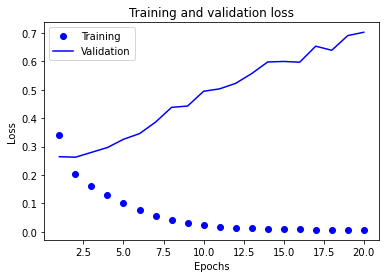

In [14]:
#Adapted from Chollet, DLWP, Listing 3.19 and 3.20, page 81
#and lecture 9.305 Validating your approach of week 17 of CM3015 
plot_epochs(range(1, len(loss) + 1), 
            loss, 'bo', 'Training',
            val_loss, 'b', 'Validation',
            'Training and validation loss',
            'Epochs',
            'Loss')

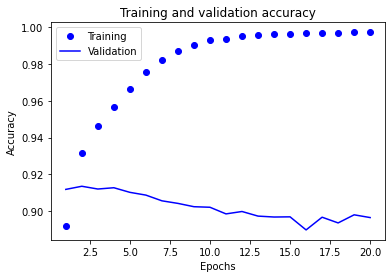

In [15]:
#Adapted from Chollet, DLWP, Listing 3.19 and 3.20, page 81
#and lecture 9.305 Validating your approach of week 17 of CM3015 
plot_epochs(range(1, len(loss) + 1), 
            acc, 'bo', 'Training',
            val_acc, 'b', 'Validation',
            'Training and validation accuracy',
            'Epochs',
            'Accuracy')

We can see that validation loss stays is at its minimum value around the second epoch. The second epoch is also a point of the highest accuracy.

In [16]:
target_epoch_number = 2

###  Retrain model on all samples

In [17]:
#Adapted from Chollet, DLWP, Listing 3.21, page 82

model = build_model()

model.fit(x_train,
           one_hot_train_labels,
           epochs = target_epoch_number,
           batch_size = 512)

Epoch 1/2
235/235 [==============================] - 25s 103ms/step - loss: 0.3311 - accuracy: 0.8953
Epoch 2/2
235/235 [==============================] - 24s 102ms/step - loss: 0.2030 - accuracy: 0.9315


# Results

### Getting the results

In [18]:
#Adapted from Chollet, DLWP, Listing 3.21, page 82
results = model.evaluate(x_test, one_hot_test_labels)
results

238/238 [==============================] - 1s 4ms/step - loss: 0.2662 - accuracy: 0.9126


[0.26615315675735474, 0.9126315712928772]

### Comparing with baseline model

Let's compare accuracy of our model with an accuracy random baseline model.

In [19]:
#lecture "9.307 Generating predictions on new data" of week 17 of CM3015 
totals = np.zeros(4)
for i in range(len(train_labels)):
    totals[train_labels[i]] += 1
indx = np.argmax(totals)
hits = np.array(test_labels) == indx
print(np.sum(hits) / len(test_labels))

0.25


Accuracy of a random baseline model is 0.25 which is drastically lower than accuracy of our model.

### Exploring predictions

In [20]:
#Ada[ted from lecture "9.307 Generating predictions on new data" of week 17 of CM3015 
predictions = model.predict(x_test)
print('indx','\t','pred','\t','label')
for i in range(100):
    print(i, '\t', np.argmax(predictions[i]),'\t', test_labels[i])

indx 	 pred 	 label
0 	 3 	 3
1 	 1 	 1
2 	 1 	 1
3 	 0 	 0
4 	 1 	 1
5 	 0 	 0
6 	 3 	 3
7 	 1 	 1
8 	 2 	 2
9 	 3 	 3
10 	 0 	 0
11 	 0 	 0
12 	 2 	 2
13 	 0 	 0
14 	 0 	 0
15 	 1 	 1
16 	 1 	 1
17 	 3 	 3
18 	 3 	 2
19 	 0 	 0
20 	 2 	 2
21 	 3 	 3
22 	 0 	 0
23 	 2 	 2
24 	 2 	 3
25 	 0 	 0
26 	 3 	 3
27 	 0 	 0
28 	 2 	 2
29 	 3 	 0
30 	 3 	 3
31 	 1 	 3
32 	 2 	 2
33 	 3 	 3
34 	 3 	 2
35 	 3 	 3
36 	 0 	 0
37 	 2 	 3
38 	 1 	 1
39 	 2 	 3
40 	 3 	 0
41 	 2 	 2
42 	 0 	 0
43 	 1 	 1
44 	 2 	 2
45 	 1 	 1
46 	 0 	 0
47 	 1 	 1
48 	 2 	 2
49 	 3 	 3
50 	 0 	 0
51 	 3 	 3
52 	 1 	 1
53 	 2 	 2
54 	 1 	 1
55 	 3 	 3
56 	 2 	 2
57 	 2 	 0
58 	 3 	 3
59 	 2 	 3
60 	 0 	 0
61 	 1 	 1
62 	 1 	 1
63 	 3 	 3
64 	 3 	 3
65 	 2 	 2
66 	 0 	 0
67 	 2 	 3
68 	 3 	 3
69 	 0 	 0
70 	 2 	 2
71 	 3 	 3
72 	 0 	 0
73 	 3 	 3
74 	 1 	 1
75 	 0 	 0
76 	 3 	 3
77 	 1 	 1
78 	 1 	 1
79 	 3 	 2
80 	 0 	 0
81 	 2 	 2
82 	 3 	 3
83 	 0 	 0
84 	 2 	 2
85 	 1 	 1
86 	 0 	 0
87 	 3 	 3
88 	 3 	 3
89 	 1 	 1


Let's see into the a misprediction

In [21]:
miss_indx = None
predicted = None 
for i, x in enumerate(predictions):
    if np.argmax(x) != test_labels[i]:
        predicted = np.argmax(x)
        miss_indx = i                
        break;
        
print('Description:')
print(tokenizer.sequences_to_texts([test_data[miss_indx]])[0])
print()
print('Predicted:')
print(labels[predicted])
print()
print('Actual:')
print(labels[test_labels[i]])

Description:
accountingweb com october 06 2004 the opening of a trial related to oracle 39 s takeover bid of peoplesoft featured the revelation that ceo craig conway was fired last week for making misleading statements about peoplesoft 39 s sales

Predicted:
Sci/Tech

Actual:
Business


We can see that this passage contains keywords from both categories and it is really quite hard to attribute it either to one or to another. I think the misprediciton is justified here.

# Conclusions

We have sucessfully solved a text categorization problem on ag_news_subset dataset using a universal machine learning workflow defined by Francois Chollet in his "Deep Learning with Python" book. The data preporcessing included tranforming text data into vectors of floats which we then feed in the deep learning model. We have use validation on subset of training data to determine a number of epoches optimal to avoid overfitting on the training data. The final accuary of the model is above 90% which is significantly higher than a random choice of 25%. The only mispredicitons are likely those which can be equally attributed to different categories even by us humans, for example an article which contains information on stock prices of a tech company with lots of technical details could easily be classified either as Business or as Sci/Tech.

# Sources

1. Chollet, Francois. 2017. Deep Learning with Python. New York, NY: Manning Publications.
2. Xiang Zhang, Junbo Zhao and Yann LeCun. 2015. Character-level Convolutional Networks for Text Classification.
3. "AG news subset” Tensorflow. September 04, 2021. https://www.tensorflow.org/datasets/catalog/ag_news_subset.
4. "TensorFlow Datasets” Tensorflow. September 04, 2021. https://www.tensorflow.org/datasets/overview.
